# Rakenna luokittelumalli: Herkulliset aasialaiset ja intialaiset ruoat


## Keittiöluokittelijat 1

Tässä oppitunnissa tutustumme erilaisiin luokittelijoihin, joiden avulla *ennustetaan tietty kansallinen keittiö ryhmän ainesosien perusteella.* Samalla opimme lisää tavoista, joilla algoritmeja voidaan hyödyntää luokittelutehtävissä.

### [**Esiluennon kysely**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Valmistelu**

Tämä oppitunti pohjautuu [edelliseen oppituntiimme](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), jossa:

-   Teimme lempeän johdannon luokitteluihin käyttäen aineistona kaikkia Aasian ja Intian upeita keittiöitä 😋.

-   Tutustuimme joihinkin [dplyr-verbeihin](https://dplyr.tidyverse.org/) datan valmisteluun ja puhdistamiseen.

-   Loimme kauniita visualisointeja ggplot2:n avulla.

-   Näytimme, kuinka käsitellä epätasapainoista dataa esikäsittelemällä sitä [recipes-paketin](https://recipes.tidymodels.org/articles/Simple_Example.html) avulla.

-   Näytimme, kuinka `prep`- ja `bake`-toiminnot varmistavat, että resepti toimii odotetusti.

#### **Edellytykset**

Tätä oppituntia varten tarvitsemme seuraavat paketit datan puhdistamiseen, valmisteluun ja visualisointiin:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) on [R-pakettien kokoelma](https://www.tidyverse.org/packages), joka tekee data-analytiikasta nopeampaa, helpompaa ja hauskempaa!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) on [pakettikokoelma](https://www.tidymodels.org/packages/) mallinnukseen ja koneoppimiseen.

-   `themis`: [themis-paketti](https://themis.tidymodels.org/) tarjoaa lisäaskelia epätasapainoisen datan käsittelyyn.

-   `nnet`: [nnet-paketti](https://cran.r-project.org/web/packages/nnet/nnet.pdf) sisältää funktioita syöttöverkkojen arviointiin, joissa on yksi piilotettu kerros, sekä multinomiaalisten logististen regressiomallien arviointiin.

Voit asentaa ne seuraavasti:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Vaihtoehtoisesti alla oleva skripti tarkistaa, onko sinulla tämän moduulin suorittamiseen tarvittavat paketit, ja asentaa ne puolestasi, jos ne puuttuvat.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Jaa data harjoitus- ja testijoukkoihin.

Aloitetaan valitsemalla muutama vaihe edellisestä oppitunnistamme.

### Poista yleisimmät ainesosat, jotka aiheuttavat sekaannusta eri keittiöiden välillä, käyttämällä `dplyr::select()`.

Kaikki rakastavat riisiä, valkosipulia ja inkivääriä!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Hienoa! Nyt on aika jakaa data siten, että 70 % datasta menee koulutukseen ja 30 % testaukseen. Käytämme myös `stratifiointitekniikkaa` datan jakamisessa, jotta `kunkin keittiön osuus` säilyy koulutus- ja validointidatassa.

[rsample](https://rsample.tidymodels.org/), Tidymodels-paketti, tarjoaa infrastruktuurin tehokkaaseen datan jakamiseen ja uudelleennäytteistämiseen:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Epätasapainoisen datan käsittely

Kuten olet ehkä huomannut alkuperäisessä aineistossa sekä harjoitusaineistossamme, keittiöiden määrässä on melko epätasainen jakauma. Korealaisia keittiöitä on *melkein* kolme kertaa enemmän kuin thaimaalaisia keittiöitä. Epätasapainoinen data vaikuttaa usein negatiivisesti mallin suorituskykyyn. Monet mallit toimivat parhaiten, kun havaintojen määrä on tasainen, ja siksi ne saattavat kohdata haasteita epätasapainoisen datan kanssa.

Epätasapainoisen datan käsittelyyn on pääasiassa kaksi tapaa:

-   havaintojen lisääminen vähemmistöluokkaan: `Yliotanta` esimerkiksi käyttämällä SMOTE-algoritmia, joka synteettisesti luo uusia esimerkkejä vähemmistöluokasta näiden tapausten lähimpien naapureiden avulla.

-   havaintojen poistaminen enemmistöluokasta: `Aliotanta`

Edellisessä oppitunnissamme näytimme, kuinka epätasapainoista dataa voidaan käsitellä käyttämällä `reseptiä`. Reseptiä voi ajatella suunnitelmana, joka kuvaa, mitä vaiheita aineistolle tulisi soveltaa, jotta se olisi valmis data-analyysiin. Meidän tapauksessamme haluamme saavuttaa tasaisen jakauman keittiöiden määrässä `harjoitusaineistossamme`. Mennään suoraan asiaan.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Voit tietenkin vahvistaa (käyttämällä prep+bake), että resepti toimii odotetusti - kaikilla keittiömerkinnöillä on `559` havaintoa.

Koska käytämme tätä reseptiä esikäsittelijänä mallinnusta varten, `workflow()` hoitaa kaiken valmistelun ja leivonnan puolestamme, joten meidän ei tarvitse arvioida reseptiä manuaalisesti.

Nyt olemme valmiita kouluttamaan mallin 👩‍💻👨‍💻!

## 3. Luokittelijan valitseminen

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Taiteilija: @allison_horst</figcaption>


Nyt meidän täytyy päättää, mitä algoritmia käytetään tähän tehtävään 🤔.

Tidymodels-paketissa [`parsnip-paketti`](https://parsnip.tidymodels.org/index.html) tarjoaa yhtenäisen rajapinnan mallien kanssa työskentelyyn eri moottoreiden (pakettien) välillä. Katso parsnip-dokumentaatio tutkiaksesi [mallityyppejä ja moottoreita](https://www.tidymodels.org/find/parsnip/#models) sekä niiden vastaavia [malliargumentteja](https://www.tidymodels.org/find/parsnip/#model-args). Vaihtoehtojen määrä voi aluksi tuntua hämmentävältä. Esimerkiksi seuraavat menetelmät sisältävät luokittelutekniikoita:

-   C5.0 sääntöpohjaiset luokittelumallit

-   Joustavat diskriminanttimallit

-   Lineaariset diskriminanttimallit

-   Regularisoidut diskriminanttimallit

-   Logistisen regressioanalyysin mallit

-   Multinomiaalisen regressioanalyysin mallit

-   Naive Bayes -mallit

-   Tukivektorikoneet

-   Lähimmät naapurit

-   Päätöspuut

-   Yhdistelmämallit

-   Neuroverkot

Lista jatkuu!

### **Mikä luokittelija valita?**

Joten, minkä luokittelijan valitset? Usein useiden kokeileminen ja hyvän tuloksen etsiminen on tapa testata.

> AutoML ratkaisee tämän ongelman kätevästi suorittamalla nämä vertailut pilvessä, jolloin voit valita parhaan algoritmin datallesi. Kokeile sitä [täällä](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Luokittelijan valinta riippuu myös ongelmastamme. Esimerkiksi, kun tulos voidaan luokitella `useampaan kuin kahteen luokkaan`, kuten meidän tapauksessamme, sinun täytyy käyttää `moniluokkaluokittelualgoritmia` sen sijaan, että käyttäisit `binääriluokittelua.`

### **Parempi lähestymistapa**

Parempi tapa kuin arvailu on seurata ideoita tästä ladattavasta [ML Cheat Sheetistä](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Tässä huomaamme, että moniluokkaongelmaamme varten meillä on joitakin vaihtoehtoja:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Microsoftin algoritmipetoksen osio, joka esittelee moniluokkaluokitteluvaihtoehtoja</figcaption>


### **Päättely**

Katsotaan, voimmeko järkeillä eri lähestymistapoja annettujen rajoitusten puitteissa:

-   **Syvät neuroverkot ovat liian raskaita**. Koska datasetti on siisti mutta minimaalinen, ja koulutus tapahtuu paikallisesti muistikirjojen kautta, syvät neuroverkot ovat liian raskaita tähän tehtävään.

-   **Ei kaksiluokkaista luokittelijaa**. Emme käytä kaksiluokkaista luokittelijaa, joten tämä sulkee pois one-vs-all-menetelmän.

-   **Päätöspuu tai logistinen regressio voisi toimia**. Päätöspuu voisi toimia, tai multinomiaalinen regressio/moniluokkainen logistinen regressio moniluokkaiselle datalle.

-   **Moniluokkainen Boosted Decision Tree ratkaisee eri ongelman**. Moniluokkainen Boosted Decision Tree sopii parhaiten ei-parametrisiin tehtäviin, kuten tehtäviin, jotka on suunniteltu luomaan järjestyksiä, joten se ei ole hyödyllinen meille.

Yleensä ennen monimutkaisempien koneoppimismallien, kuten ensemble-menetelmien, käyttämistä on hyvä idea rakentaa mahdollisimman yksinkertainen malli, jotta saadaan käsitys siitä, mitä tapahtuu. Tässä oppitunnissa aloitamme `multinomiaalisen regressiomallin` rakentamisella.

> Logistinen regressio on tekniikka, jota käytetään, kun tulosmuuttuja on kategorinen (tai nimellinen). Binäärisessä logistisessa regressiossa tulosmuuttujien määrä on kaksi, kun taas multinomiaalisen logistisen regressiomallin tulosmuuttujien määrä on enemmän kuin kaksi. Katso [Edistyneet regressiomenetelmät](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) lisälukemista varten.

## 4. Kouluta ja arvioi multinomiaalinen logistisen regressiomalli.

Tidymodelsissa `parsnip::multinom_reg()` määrittelee mallin, joka käyttää lineaarisia ennustajia moniluokkaisen datan ennustamiseen multinomiaalisen jakauman avulla. Katso `?multinom_reg()` saadaksesi lisätietoa tavoista/moottoreista, joita voit käyttää tämän mallin sovittamiseen.

Tässä esimerkissä sovitamme multinomiaalisen regressiomallin oletusmoottorilla [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Valitsin arvon `penalty` hieman satunnaisesti. On olemassa parempia tapoja valita tämä arvo, esimerkiksi käyttämällä `resampling`-menetelmää ja `mallin viritystä`, joista keskustelemme myöhemmin.
>
> Katso [Tidymodels: Aloita](https://www.tidymodels.org/start/tuning/) jos haluat oppia lisää mallin hyperparametrien virittämisestä.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Hienoa työtä 🥳! Nyt kun meillä on resepti ja mallin määrittely, meidän täytyy löytää tapa yhdistää ne yhdeksi objektiksi, joka ensin esikäsittelee datan, sitten sovittaa mallin esikäsiteltyyn dataan ja mahdollistaa myös mahdolliset jälkikäsittelytoiminnot. Tidymodels-kirjastossa tämä kätevä objekti kutsutaan [`workflow`](https://workflows.tidymodels.org/), ja se sisältää kätevästi mallinnuskomponenttisi! Tätä kutsuttaisiin *putkistoiksi* (*pipelines*) *Pythonissa*.

Joten yhdistetään kaikki workflowksi!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Työnkulut 👌👌! **`workflow()`** voidaan sovittaa samalla tavalla kuin malli. Joten, aika kouluttaa malli!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Mallin oppimat kertoimet näytetään koulutuksen aikana.

### Arvioi koulutettu malli

On aika nähdä, miten malli suoriutui 📏 arvioimalla sitä testijoukolla! Aloitetaan tekemällä ennusteita testijoukolle.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Hienoa työtä! Tidymodelsissa mallin suorituskykyä voidaan arvioida käyttämällä [yardstick](https://yardstick.tidymodels.org/)-pakettia, joka mittaa mallien tehokkuutta suorituskykymittareiden avulla. Kuten teimme logistisen regressio -oppitunnissamme, aloitetaan laskemalla sekaannusmatriisi.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Kun käsitellään useita luokkia, on yleensä intuitiivisempaa visualisoida tämä lämpökarttana, kuten tämä:


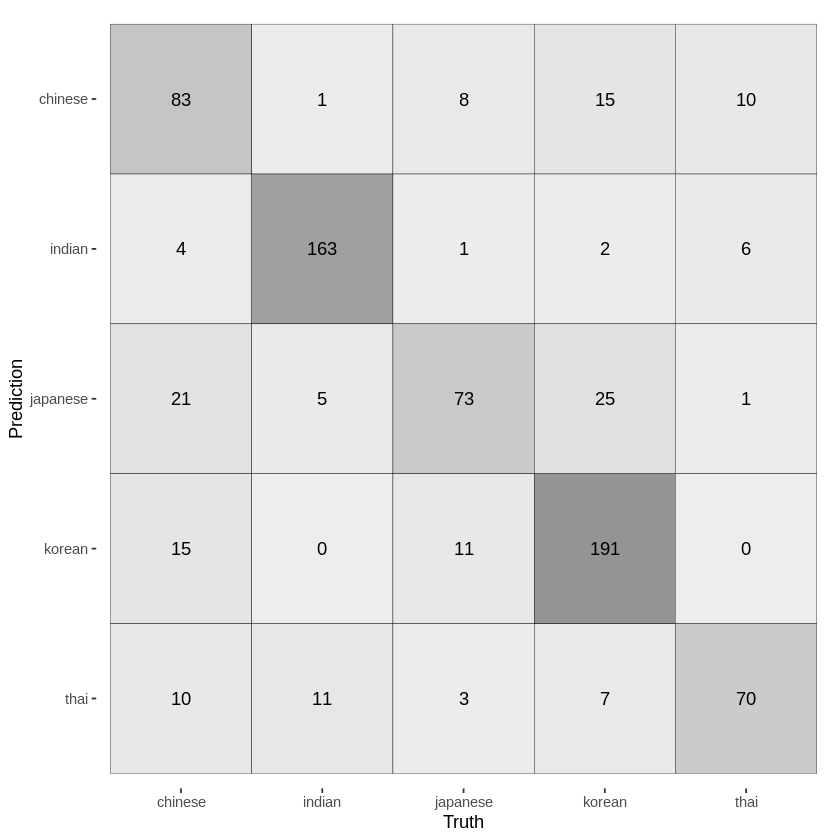

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Tummemmat ruudut sekaannusmatriisin kaaviossa osoittavat suuria tapausmääriä, ja toivottavasti näet tummempien ruutujen muodostaman diagonaaliviivan, joka osoittaa tapaukset, joissa ennustettu ja todellinen luokitus ovat samat.

Lasketaan nyt yhteenvetotilastot sekaannusmatriisille.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Jos tarkastelemme joitakin mittareita, kuten tarkkuutta, herkkyyttä ja ppv:tä, emme ole huonossa tilanteessa aluksi 🥳!

## 4. Syvemmälle sukeltaminen

Kysytään yksi hienovarainen kysymys: Mitä kriteerejä käytetään valitsemaan tietty keittiötyyppi ennustetuksi lopputulokseksi?

No, tilastolliset koneoppimisalgoritmit, kuten logistinen regressio, perustuvat `todennäköisyyteen`; joten mitä luokitin oikeastaan ennustaa, on todennäköisyysjakauma mahdollisten lopputulosten joukossa. Luokka, jolla on korkein todennäköisyys, valitaan sitten todennäköisimmäksi lopputulokseksi annettujen havaintojen perusteella.

Katsotaanpa tämä käytännössä tekemällä sekä kovia luokkien ennusteita että todennäköisyyksiä.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Paljon parempi!

✅ Voitko selittää, miksi malli on melko varma, että ensimmäinen havainto on thaimaalainen?

## **🚀Haaste**

Tässä oppitunnissa käytit puhdistettuja tietojasi rakentaaksesi koneoppimismallin, joka voi ennustaa kansallisen keittiön ainesosien perusteella. Käytä hetki aikaa tutustuaksesi [moniin vaihtoehtoihin](https://www.tidymodels.org/find/parsnip/#models), joita Tidymodels tarjoaa datan luokitteluun, sekä [muihin tapoihin](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) sovittaa multinomiaalista regressiota.

#### KIITOS:

[`Allison Horst`](https://twitter.com/allison_horst/) upeiden kuvitusten luomisesta, jotka tekevät R:stä kutsuvamman ja kiinnostavamman. Löydä lisää kuvituksia hänen [galleriastaan](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) ja [Jen Looper](https://www.twitter.com/jenlooper) alkuperäisen Python-version luomisesta tähän moduuliin ♥️

<br>
Olisin voinut heittää mukaan muutaman vitsin, mutta en ymmärrä ruokapiloja 😅.

<br>

Hyvää oppimista,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Vastuuvapauslauseke**:  
Tämä asiakirja on käännetty käyttämällä tekoälypohjaista käännöspalvelua [Co-op Translator](https://github.com/Azure/co-op-translator). Vaikka pyrimme tarkkuuteen, huomioithan, että automaattiset käännökset voivat sisältää virheitä tai epätarkkuuksia. Alkuperäistä asiakirjaa sen alkuperäisellä kielellä tulisi pitää ensisijaisena lähteenä. Kriittisen tiedon osalta suositellaan ammattimaista ihmiskäännöstä. Emme ole vastuussa väärinkäsityksistä tai virhetulkinnoista, jotka johtuvat tämän käännöksen käytöstä.
